#Test training on a larger subset of the iNaturalist Dataset

In this notebook, we will be experimenting with expanding a pre-trained image recognition model based on this [tensorflow guide](https://www.tensorflow.org/tutorials/images/classification). We will be expanding it by training a model with the exact same architecture to recognise 10 animal species from the [iNaturalist 2021](https://github.com/visipedia/inat_comp/tree/master/2021) validation and mini training dataset.


#Load iNaturalist Training Dataset

##Imports

In [ ]:
# For loading in dataset images and annotations
import json
import os

from etils import epath
import numpy as np
import tensorflow_datasets.public_api as tfds

# Displaying sample images
import itertools

import tarfile
import glob
import re
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

##Downloading different splits

In [ ]:
dm = tfds.download.DownloadManager(download_dir='/home')

URL = 'https://ml-inat-competition-datasets.s3.amazonaws.com/2021'    # endpoint to load images from

# maps split type to split file name
SPLIT_FILENAMES = {
    'train': 'train',
    'mini': 'train_mini',
    'val': 'val',
    'test': 'public_test',
}

# initalise the splits we are interested in
SPLITS = ['mini', 'val']
# get splits resource name
SPLIT_FILE = [SPLIT_FILENAMES[split] for split in SPLITS]

# maps dataset to split tar & json files
splitDownloads = {}

In [ ]:
# downloading the tar file containing validation images

for count, split in enumerate(SPLITS):
  # download image tar file
  splitDownloads[f'{split}_img'] =  tfds.download.Resource(
            url=f'{URL}/{SPLIT_FILE[count]}.tar.gz',
            extract_method=tfds.download.ExtractMethod.NO_EXTRACT,
        )
  # download json annotation file
  splitDownloads[f'{split}_json'] = f'{URL}/{SPLIT_FILE[count]}.json.tar.gz'

print(splitDownloads)

outputPaths = dm.download_and_extract(splitDownloads)

{'mini_img': <tensorflow_datasets.core.download.resource.Resource object at 0x79823b0a33a0>, 'mini_json': 'https://ml-inat-competition-datasets.s3.amazonaws.com/2021/train_mini.json.tar.gz', 'val_img': <tensorflow_datasets.core.download.resource.Resource object at 0x79823b0a3fa0>, 'val_json': 'https://ml-inat-competition-datasets.s3.amazonaws.com/2021/val.json.tar.gz'}


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

#Retrieving annotations from JSON file to load images from  datasets

##Setup

In [ ]:
# List containing the vertebrates recognised by iNaturalist Dataset
vertebrates = ["jawless_fishes", "hagfishes", "lampreys", "ray-finned_fishes", "amphibians", "birds", "elasmobranchs", "chimaeras", "mammals", "reptiles", "lobe-finned_fishes"]

In [ ]:
# List containing the animals that user want to see/train on
SPECIES_TO_RETRIEVE = sorted(['panthera_leo',
                     'falco_peregrinus',
                     'oryx_gazella',
                     'zalophus_wollebaeki',
                     'rattus_rattus',
                     'odocoileus_hemionus',
                     'scarus_ghobban',
                     'cyanoramphus_novaezelandiae',
                     'lampropeltis_nigra',
                     'varanus_varius'
                     ])

##Initalising Useful Functions

In [ ]:
# replace ' ' with '_' in a string
def format(label: str):
      return label.lower().replace(' ', '_')


# retrieves annotations (categories, id and image directory) for an image
def getAnnotation(idx, imageId, inatJson):

      if 'annotations' in inatJson:
        # get the annotations object that matches our ID
        annotation = inatJson['annotations'][idx]
        assert annotation['image_id'] == imageId

        # retrieve 'categories' object corresponding to the id in the annotation object
        cat = inatJson['categories'][annotation['category_id']]

        # extract important metadata
        category = format(cat['name'])
        superCategory = format(cat['supercategory'])
        imageDirectory = cat['image_dir_name']

      else:
        # no metadata found
        category, superCategory, imageDirectory = -1, -1, -1

      return category, superCategory, imageDirectory

## Annotating Validation dataset

Annotating the validation dataset is useful due to the fact that they create the subset of validation images consisting of images only species that we are interested in training the model on. Hence, allowing us to extract only those images from the whole validation image archive. We do not need to do this for the train_mini dataset due to the fact that we will be untaring the whole image archive. The explaination to why we will be doing this will be explained later on; know that because it is more time-efficient.

In [ ]:
# establish paths to loaded validation dataset
split = SPLITS[1]

# get paths for image archive and to annotation json file
valImagesArchive = outputPaths[f'{split}_img']
jsonFile = os.path.join(outputPaths[f'{split}_json'],f'{SPLIT_FILENAMES[split]}.json')


In [ ]:
# load json annotation
with epath.Path(jsonFile).open('r') as f:
      valInatJson = json.load(f)

In [ ]:
valAnnotatedFiles = {}   # maps unique image id to metadata species annotation

for idx, image  in enumerate(valInatJson['images']):
  category, superCategory, imageDirectory = getAnnotation(idx, image['id'], valInatJson)

# Checking if the species is a vertebrate and checking if current image is a species of animal we are interested in retrieving
  if (superCategory in vertebrates) and (category in SPECIES_TO_RETRIEVE):
    field = os.path.basename(image['file_name']).split('.')[0]

    valAnnotatedFiles[field] = {
        'id': image['id'],
        'file_id': field,
        'label': category,      # latin name
        'superCategory': superCategory,
        'imagedirectory' : imageDirectory,
    }

In [ ]:
print(valAnnotatedFiles)
print(f'There are a total of {len(valAnnotatedFiles)} annotations in the validation dataset')

{'adf72101-b85a-4a08-9cd7-1e06f482c35a': {'id': 2686900, 'file_id': 'adf72101-b85a-4a08-9cd7-1e06f482c35a', 'label': 'lampropeltis_nigra', 'superCategory': 'reptiles', 'imagedirectory': '04923_Animalia_Chordata_Reptilia_Squamata_Colubridae_Lampropeltis_nigra'}, '1d7e4f80-9f07-4018-a424-fab5f1694365': {'id': 2686969, 'file_id': '1d7e4f80-9f07-4018-a424-fab5f1694365', 'label': 'varanus_varius', 'superCategory': 'reptiles', 'imagedirectory': '05105_Animalia_Chordata_Reptilia_Squamata_Varanidae_Varanus_varius'}, '300262a5-cf42-4296-ad50-d9d305e19a80': {'id': 2687910, 'file_id': '300262a5-cf42-4296-ad50-d9d305e19a80', 'label': 'panthera_leo', 'superCategory': 'mammals', 'imagedirectory': '04682_Animalia_Chordata_Mammalia_Carnivora_Felidae_Panthera_leo'}, '4e67ecf3-25ce-4098-958c-2c829757fe0c': {'id': 2688922, 'file_id': '4e67ecf3-25ce-4098-958c-2c829757fe0c', 'label': 'lampropeltis_nigra', 'superCategory': 'reptiles', 'imagedirectory': '04923_Animalia_Chordata_Reptilia_Squamata_Colubridae_L

# Extracting images

## validation images

Extracting validation images we are interested in by generating an absolute path to each image.

In [ ]:
# contains image file paths in tar.gz file
imgToExtract = []

try:
  t = tarfile.open(valImagesArchive, 'r')

except IOError as e:
  print(e)

else:
  for id,value in valAnnotatedFiles.items():
    # create image file path
    imgFilePath = f"val/{value['imagedirectory']}/{id}.jpg"         # specfying the file path to store the extracted images
    imgToExtract.append(imgFilePath)

  # extract all images of species we are interested in
  t.extractall('/content', members=imgToExtract)

##Train-mini images

Instead of extracting specific images only relating to the animals contained in the `SPECIES_TO_RETRIEVE`, we are extracting all images from the train-mini dataset. Why? Because through some experimentation it was more time-efficient to untar the whole archive, which takes around 40 minutes. Compared to compiling a list of absolute file image paths, which took around 30 minutes to extract one image.

In [ ]:
# image file paths in tar.gz file
imgToExtract = []

try:
  t = tarfile.open(trainImagesArchive, 'r')

except IOError as e:
  print(e)

else:
  t.extractall('/content')

Next, we delete the species classes that we are not concerned with training. This is because we do not create an imbalance in data where we train on all species classes but we only validate with a selected subset of species. However, this opens up the possibility for us to train the model on the whole index of species.

In [ ]:
# deleting classes we are not training
import os,sys
import shutil

# get directory paths of species we want to train by getting all directory names
# from our extracted validation dataset. Because we didn't download the whole validation dataset
speciesDir = []

for id,value in valAnnotatedFiles.items():
    if value['imagedirectory'] not in speciesDir:
      speciesDir.append(value['imagedirectory'])

# get train_mini extracted dataset path
path = '/content/train_mini'
# get list of directories in train_mini
dirs = os.listdir( path )
for d in dirs:
  # if train_mini directory's name does not match an existing directory in our validation dataset
  if d not in speciesDir:
    try:
      # delete species directory
      shutil.rmtree(os.path.join(path, d))
    except:
      print(f'error with directory {os.path.join(path, d)}')


Finally, we will be renaming all directory names and cropping the images. Renaming the directory names simply allows for clearer class names, as directories will be shorten to just the species latin names.

The central cropping of all images is needed as the input size of the model is immutable and since the [iNaturalist dataset](https://github.com/visipedia/inat_comp/tree/master/2021) specifies that all images have a max dimension of 500px. However, as photographers can publish pictures with different aspect ratios and orientations. This leads inconsistent image dimensions in the dataset. To combat this, all images will be cropped centrally and resized to 200px by 200px.

In [ ]:
imgHeight = 200
imgWidth = 200

In [ ]:
from PIL import Image
# rename all folders to match class names of the validation dataset
path = '/content/val'
dirs = os.listdir(path)

for folder in dirs:
    # rename species folder
  os.rename(f"{path}/{folder}", f"{path}/{'_'.join(folder.split('_')[6::])}_images")

  # get path of each image in class folder
  newPath = f"{path}/{'_'.join(folder.split('_')[6::])}_images"
  imageDir = os.listdir(newPath)

  for item in imageDir:
    print(f"Currently manipulating {item}")
    im = Image.open(itemPath)

    # cropping the images to square aspect ratio
    width, height = im.size
    minDimension = min(width, height)
    # left(x), upper(y), right(x), lower(y)
    imgMidArea = ((width - minDimension) // 2,
                    (height - minDimension) // 2,
                    ((width - minDimension) // 2) + minDimension,
                      ((height - minDimension) // 2) + minDimension)
    imgCropped = im.crop(imgMidArea)

    # resize square cropped images to 200x200px
    imResize = imgCropped.resize((imgWidth,imgHeight))

    imResize.save(itemPath,'JPEG', quality=90)

In [ ]:

# rename all folders to match class names of the training dataset
path = '/content/train_mini'
dirs = os.listdir(path)

for folder in dirs:
  # get path of each image in class folder
    # rename species folder
  os.rename(f"{path}/{folder}", f"{path}/{'_'.join(folder.split('_')[6::])}_images")

  # get path of each image in class folder
  newPath = f"{path}/{'_'.join(folder.split('_')[6::])}_images"
  imageDir = os.listdir(newPath)

  for item in imageDir:
    print(f"Currently manipulating {item}")
    im = Image.open(itemPath)

    # cropping the images to square aspect ratio
    width, height = im.size
    minDimension = min(width, height)
    # left(x), upper(y), right(x), lower(y)
    imgMidArea = ((width - minDimension) // 2,
                    (height - minDimension) // 2,
                    ((width - minDimension) // 2) + minDimension,
                      ((height - minDimension) // 2) + minDimension)
    imgCropped = im.crop(imgMidArea)

    # resize square cropped images to 200x200px
    imResize = imgCropped.resize((imgWidth,imgHeight))

    imResize.save(itemPath,'JPEG', quality=90)

# Building the Model



##Imports


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# python imaging library
# adds image processing capabilities to the interpreter
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

##Checking number of images

In [ ]:
import pathlib
valDataDir = pathlib.Path('/content/val').with_suffix('')      # directory that stores the training data

# image count for val
imageCount = len(list(valDataDir.glob('*/*.jpg')))
print(imageCount)


trainDataDir = pathlib.Path('/content/train_mini').with_suffix('')      # directory that stores the training data

# image count for training
imageCount = len(list(trainDataDir.glob('*/*.jpg')))
print(imageCount)

100
500


## Preprocessing / Creating Datasets

In [ ]:
batchSize = 32

##Training dataset

In [ ]:
# Creating the training dataset
trainDs = tf.keras.utils.image_dataset_from_directory(
  trainDataDir,
  validation_split=None,
  subset = None,
  seed=123,
  image_size=(imgHeight, imgWidth),
  batch_size=batchSize)

Found 500 files belonging to 10 classes.


In [ ]:
# Identifying class names that model has to train for. These the species the user selected to train on.
classNames = trainDs.class_names
print(classNames)

['Cyanoramphus_novaezelandiae_images', 'Falco_peregrinus_images', 'Lampropeltis_nigra_images', 'Odocoileus_hemionus_images', 'Oryx_gazella_images', 'Panthera_leo_images', 'Rattus_rattus_images', 'Scarus_ghobban_images', 'Varanus_varius_images', 'Zalophus_wollebaeki_images']


##Validation dataset

In [ ]:
# Creating the validation dataset
valDs = tf.keras.utils.image_dataset_from_directory(
  valDataDir,
  validation_split=None,
  subset = None,
  seed=123,
  image_size=(imgHeight, imgWidth),
  batch_size=batchSize)

Found 100 files belonging to 10 classes.


##Other

In [ ]:
# validate that both the training and validation dataset contain the same classes
assert trainDs.class_names == valDs.class_names

In [ ]:
for imageBatch, labelsBatch in trainDs:
  print(imageBatch.shape)
  print(labelsBatch.shape)
  break

(32, 200, 200, 3)
(32,)


## Configuring dataset for performance

In [ ]:
# Prefetching and caching the datasets to memory
AUTOTUNE = tf.data.AUTOTUNE

trainDs = trainDs.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
valDs = valDs.cache().prefetch(buffer_size=AUTOTUNE)

##Standarise Data

RGB channel values are in the range `[0,255]`. But this is not ideal for NN, so need to make input values small.

Use `tf.keras.layers.Rescaling` to standardise values to `[0,1]` range.

In [ ]:
normalisationLayer = layers.Rescaling(1./255)

## Creating the Model

In [ ]:
# Note model has not been tuned for high accuracry

num_classes = len(classNames)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(imgHeight, imgWidth, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

#Compile the Model

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 200, 200, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 200, 200, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 100, 100, 16)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 100, 100, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 50, 50, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 50, 50, 64)        1

#Training the Model

In [ ]:
epochs=10
history = model.fit(
  trainDs,
  validation_data=valDs,
  epochs=epochs
)

Epoch 1/10
16/16 [==============================] - 15s 708ms/step - loss: 2.6572 - accuracy: 0.1400 - val_loss: 2.1877 - val_accuracy: 0.1900
Epoch 2/10
16/16 [==============================] - 10s 653ms/step - loss: 2.1150 - accuracy: 0.2180 - val_loss: 1.9775 - val_accuracy: 0.3300
Epoch 3/10
16/16 [==============================] - 11s 660ms/step - loss: 1.8695 - accuracy: 0.3360 - val_loss: 1.7674 - val_accuracy: 0.4000
Epoch 4/10
16/16 [==============================] - 10s 654ms/step - loss: 1.6851 - accuracy: 0.4280 - val_loss: 1.7226 - val_accuracy: 0.3800
Epoch 5/10
16/16 [==============================] - 11s 670ms/step - loss: 1.4539 - accuracy: 0.5060 - val_loss: 1.7069 - val_accuracy: 0.4400
Epoch 6/10
16/16 [==============================] - 11s 665ms/step - loss: 1.1397 - accuracy: 0.6360 - val_loss: 1.8284 - val_accuracy: 0.3900
Epoch 7/10
16/16 [==============================] - 11s 675ms/step - loss: 1.0183 - accuracy: 0.6640 - val_loss: 1.8814 - val_accuracy: 0.4200

#Visualising training results

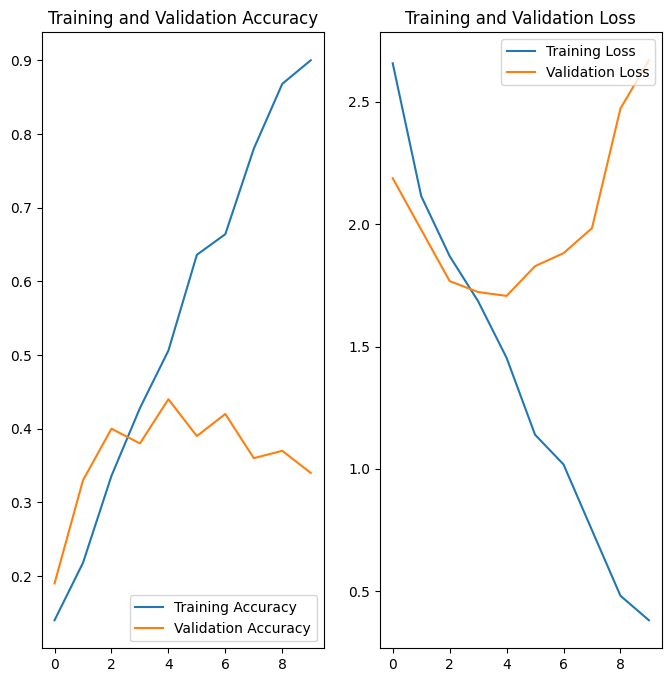

In [ ]:
acc = history.history['accuracy']
valAcc = history.history['val_accuracy']

loss = history.history['loss']
valLoss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, valAcc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, valLoss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Both graphs indicate that our current model is overfitted.

#Attempting to deal with Overfitting

##Data augmentation

In [ ]:
dataAugmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(imgHeight,
                                  imgWidth,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

View augmented examples:

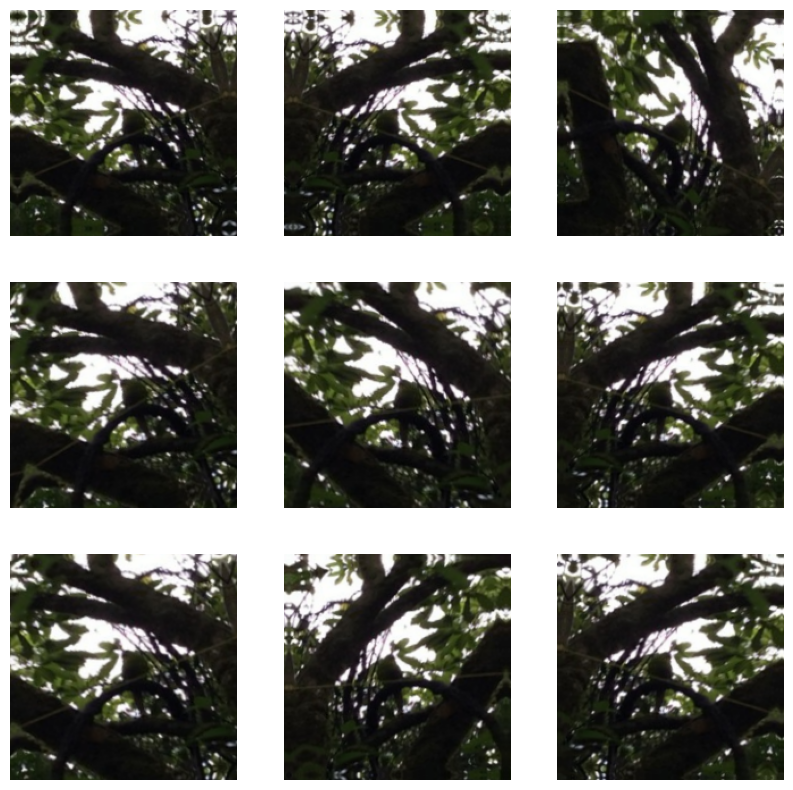

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in trainDs.take(1):
  for i in range(9):
    augmentedImages = dataAugmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmentedImages[0].numpy().astype("uint8"))
    plt.axis("off")

##Dropout

Applying dropout to a layer, it randomly drops out (by setting the activation to zero) a number of output units from the layer during the training process. Dropout takes a fractional number as its input value.

After applying dropout to a new neuralnetwork before training it using the augmented images:

In [ ]:
model = Sequential([
  dataAugmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, name="outputs")
])

##Compile and training the new tuned model

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 200, 200, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 200, 200, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 200, 200, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 100, 100, 16)      0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 100, 100, 32)      4640      
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 50, 50, 32)        0         
 g2D)                                                 

In [ ]:
epochs = 15
history = model.fit(
  trainDs,
  validation_data=valDs,
  epochs=epochs
)

Epoch 1/15
16/16 [==============================] - 14s 776ms/step - loss: 2.2831 - accuracy: 0.1620 - val_loss: 2.0787 - val_accuracy: 0.2000
Epoch 2/15
16/16 [==============================] - 13s 847ms/step - loss: 1.9873 - accuracy: 0.2860 - val_loss: 1.8925 - val_accuracy: 0.3200
Epoch 3/15
16/16 [==============================] - 12s 756ms/step - loss: 1.9266 - accuracy: 0.2460 - val_loss: 1.7182 - val_accuracy: 0.4000
Epoch 4/15
16/16 [==============================] - 12s 752ms/step - loss: 1.8901 - accuracy: 0.3220 - val_loss: 1.8586 - val_accuracy: 0.2500
Epoch 5/15
16/16 [==============================] - 12s 775ms/step - loss: 1.8333 - accuracy: 0.3280 - val_loss: 1.7536 - val_accuracy: 0.3800
Epoch 6/15
16/16 [==============================] - 12s 756ms/step - loss: 1.7383 - accuracy: 0.3920 - val_loss: 1.5783 - val_accuracy: 0.5000
Epoch 7/15
16/16 [==============================] - 14s 867ms/step - loss: 1.6911 - accuracy: 0.3800 - val_loss: 1.5842 - val_accuracy: 0.4700

##Visualing training results

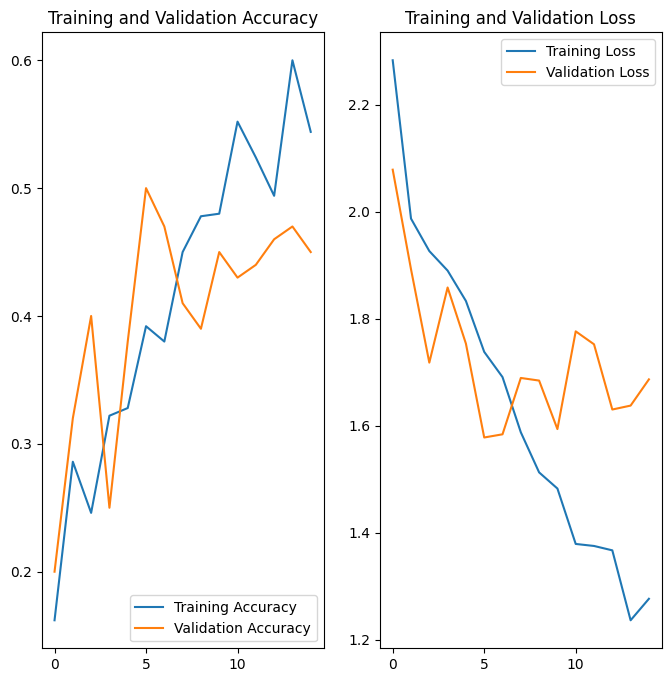

In [ ]:
acc = history.history['accuracy']
valAcc = history.history['val_accuracy']

loss = history.history['loss']
valLoss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, valAcc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, valLoss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#Conclusions and Comparisons

When compared to our inital trained model. The validation and training accuracy seems to increase at a similar rate, contrasting our initial graph which showed the validation accuracy leveling off around 0.4 while the training accuracy increases steadily to 0.9. However both the training and validation accuracy seem to average around 0.5 in this model.

As for the training and validation loss, our inital model showed that as the validation loss seemed to increase exponentially, the training loss decreases at a constant rate. Compared to our latest model which shows the validation loss at a steady increase before leveling at around 1.7 while training loss continues to decrease. This shows that the effects of overfitting have been minimised however, more can be possibly done with even more training data.

In conclusion, this notebook, displays that is is possible to train up to 10 species, possibly even the whole index of species in the iNaturalist dataset. However, when compared to this [notebook](https://colab.research.google.com/drive/1y9QXXyzu7FB66BtMm9MBrspJUPmYw5nZ?usp=sharing) where it was trained on an even small subset of 5 animal species and image resolutions were 75x75px (to 180x180px), the model has a peak validation accuracy of 64% while this notebook peaked at 50%. This could be due to a number of factors.